In [17]:
import pandas as pd
from fastai.vision.all import *

সাধারন ক্লাসিফিকেশন সমস্যাগুলোতে একটি ছবিতে এক ধরনের একটিই বস্তু থাকে যা আমরা ক্লাসিফাই করতে চাই। যেমন, আমরা যাদি একটি মডেল বানাতে চাই যা কুকুর এবং বিড়ালের ছবি ক্লাসিফাই করতে পারে, তাহলে প্রত্যেক ছবিতে শুধু একটি কুকুর অথবা একটি বিড়ালই থাকবে। এমনকি কোন ছবিতে যদি কোনটিই না থাকে, তবুও আমাদের মডেল ছবিটিকে কুকুর অথবা বিড়াল হিসেবে ক্লাসিফাই করবে। অন্যদিকে, মাল্টি-লেবেল ক্লাসিফিকেশনে আমরা একটি ছবিতে এক বা একাধিক ধরনের ভিন্ন ভিন্ন বস্তু খুঁজে বের করি। আবার এমনও হতে পারে যে ছবিতে কোন বস্তুই নেই।

মাল্টি-লেবেল ক্লাসিফিকেশনের জন্য আমরা `PASCAL` ডাটাসেটটি ব্যবহার করব। এই ডাটাসেটটি ইমেজনেটের মত ফোল্ডার বা ফাইলের নাম দিয়ে সাজানো নয়। বরং একটি সি,এস,ভি, ফাইলে প্রত্যেক ছবির ফাইলের নাম এবং এর ক্লাস দেয়া থাকে।

In [18]:
path = untar_data(URLs.PASCAL_2007)

খেয়াল কর, লেবেলস কলামে কোন কোন ছবির জন্য একাধিক লেবেল আছে। একাধিক লেবেল থাকলে তা স্পেইস দিয়ে আলাদা করা আছে।

In [19]:
metadata = pd.read_csv(path/'train.csv')
metadata.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


`PyTorch` ডাটা নিয়ে কাজ করার জন্য দুটি ক্লাস ব্যবহার করে। একটি হল `Dataset` যা মুলত ইন্ডিপেন্ডেন্ট এবং ডিপেন্ডেন্ট ভ্যারিয়েবলের একটি করে `tuple` সরবরাহ করে। আরেকটি হল `DataLoader` যা ইন্ডিপেন্ডেন্ট এবং ডিপেন্ডেন্ট ভ্যারিয়েবলের একটি করে মিনি ব্যাচ সরবরাহ করে। 

In [32]:
def get_x(r):
    return path/'train'/r['fname']

def get_y(r):
    return r['labels'].split(' ')

def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

In [40]:
dblock = DataBlock(
    blocks= (ImageBlock, MultiCategoryBlock),
    splitter=splitter,
    get_x = get_x,
    get_y = get_y,
    item_tfms = RandomResizedCrop(128, min_scale=0.35)
)

In [43]:
dls = dblock.dataloaders(metadata)

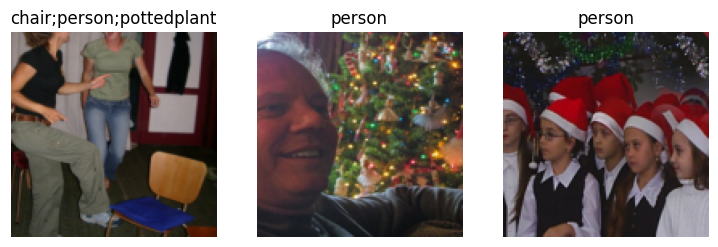

In [44]:
dls.show_batch(nrows=1, ncols=3)

In [45]:
learn = vision_learner(dls, resnet18)

C:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\musab/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:20<00:00, 2.30MB/s]


In [49]:
x, y = dls.train.one_batch()
activations = learn.model.cuda()(x)
activations.shape

torch.Size([64, 20])

In [50]:
activations[0]

TensorImage([-2.1123,  2.5649, -0.8743,  3.2839, -1.5754, -3.0424,  0.7697,
             -0.1725,  2.0850, -2.2191,  0.0935, -0.2228, -0.5062, -0.7333,
              2.1180, -1.8393, -0.6708, -1.3830, -0.1287, -1.3937],
            device='cuda:0', grad_fn=<AliasBackward0>)

In [52]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid:
        inp = inp.sigmoid()
    return ((inp > thresh) == targ.bool()).float().mean()

In [53]:
learn = vision_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

C:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\musab\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.996255,0.727432,0.190598,00:54
1,0.872648,0.577905,0.232948,00:35
2,0.641612,0.215454,0.810737,00:34
3,0.392152,0.144254,0.933048,00:35


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.156044,0.131097,0.934283,00:35
1,0.138274,0.120499,0.943606,00:35
2,0.122167,0.119351,0.943805,00:36


In [54]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.11935103684663773,0.9179083704948425]

In [55]:
preds, targs = learn.get_preds()
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

tensor(0.9487)

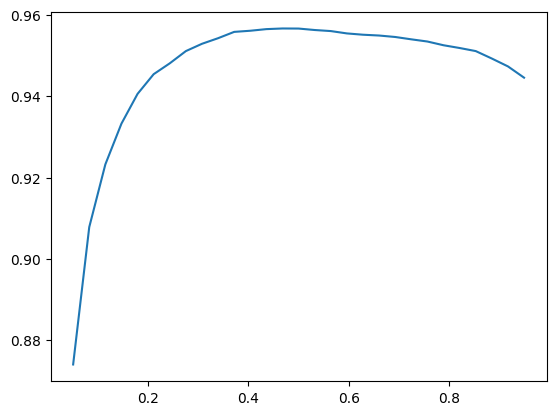

In [56]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

In [57]:
path = untar_data(URLs.BIWI_HEAD_POSE)

NameError: name 'ContentTooShortError' is not defined

In [ ]:
path.ls()

In [ ]:
(path/'01').ls()